In [1]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

import statsmodels.api as sm

#TODO:
#Definiçao da metrica de jitter no texto
#Grafico apenas dos trafegos que foram movidos em 350s - ok
#Formataçao dos graficos (legenda, cor) - ok
#Linha com a média no grafico de jitter

In [2]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0, "legend.title_fontsize": 13.75}
sns.set (style="whitegrid", font_scale=1.35, rc=myrcs)
sns.set_palette (sns.color_palette (["#90addb", "#3e6cb1", "#26354b"]))
sns.set_palette (sns.color_palette (["#9e9ac8", "#6a51a3", "#3f007d"]))

# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [3]:
#Configurações
# A5 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 5)
# A5 = (HW = 1; SW = 1-5)

# Parâmetros que variam nesta simulação
seeds = [1,2]
cargas = ["50hosts", "100hosts", "150hosts"] #"50hosts", "100hosts",
experimentos = ["a5"]

# Tempo total de simulação
t_sim = 2000

# Intervalo de confiança
confianca = 99

# Imprimir titulos nos gráficos
titulos = False

# Salvar graficos
salvarGraficos = True

In [4]:
def read_df_saidaStruct ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-saidaStruct.log", sep='\s+', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High","Time:s":"Time"}, inplace=True)
    return df_read

def read_df_cache ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-traffic-qos-l7-app.log", sep='\s+', index_col=["Teid"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_ping ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingStats.zip", sep='\s+', compression='zip', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    df_read.rename(columns={'Time:s': 'Time'}, inplace=True)
    return df_read

def read_df_regrasMovidas ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-RegrasMovidas.log", sep='\s+', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

In [5]:
df_regrasMovidas = read_df_regrasMovidas()
df_regrasMovidas.drop(columns=["SRC","DST","SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches","InCache", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_ping = read_df_ping()
df_saidaStruct = read_df_saidaStruct()
df_saidaStruct.drop(columns=["SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_concatenado = pd.merge(df_ping, df_saidaStruct, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_ping = 0
df_saidaStruct = 0
df_concatenado = pd.merge(df_concatenado, df_regrasMovidas, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_regrasMovidas = 0
df_concatenado.reset_index(inplace = True)
df_concatenado.query("TimeSec == 350.0",inplace = True)
df_concatenado = df_concatenado.groupby(["Load", "InCache", "Time"]).mean()
df_concatenado.reset_index(inplace = True)
df_concatenado["Delay:ns"] = df_concatenado["Delay:ns"]/1e6
df_concatenado["Jitter:ns"] = df_concatenado["Jitter:ns"]/1e6
#df_concatenado

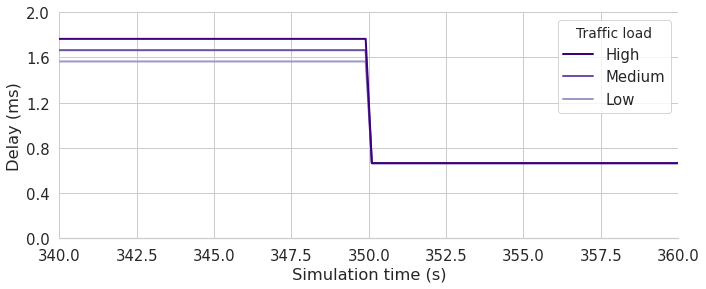

In [6]:
snsplt = sns.relplot(x="Time", y="Delay:ns", hue="Load" , col="InCache", kind="line", legend="full", facet_kws={"legend_out":False},  
                      data=df_concatenado, ci=confianca, markers=True, hue_order=["Low", "Medium", "High"])
#plt.title('50Hosts - Delay')
snsplt.set_axis_labels("Simulation time (s)", "Delay (ms)")
if (titulos):
    snsplt.fig.suptitle('50 hosts em 350s - Delay', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(340, 360))
snsplt.set(ylim=(0, 2))
snsplt.set(yticks=(0,0.4,0.8,1.2,1.6,2))
order = [2, 1, 0]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="upper right", title="Traffic load")
snsplt.ax.set_title('')
if (salvarGraficos):
    snsplt.savefig("Graficos/MovidosEm350-delay.pdf")

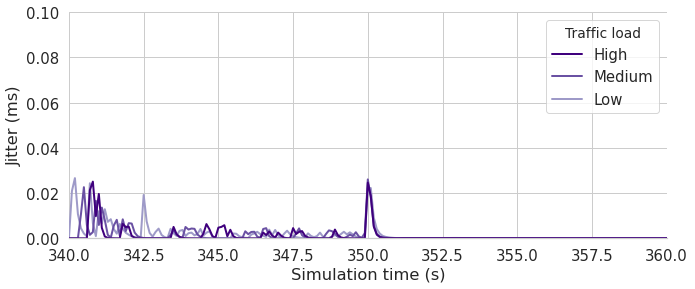

In [7]:
snsplt = sns.relplot(x="Time", y="Jitter:ns", hue="Load", col="InCache", kind="line", legend="full", facet_kws={"legend_out":False},
                      data=df_concatenado, ci=confianca, markers=True, hue_order=["Low", "Medium", "High"])
#plt.title('50Hosts- Jitter')
snsplt.set_axis_labels("Simulation time (s)", "Jitter (ms)")
if (titulos):
    snsplt.fig.suptitle('50 hosts em 350s - Jitter', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(340, 360))
snsplt.set(ylim=(0, 0.1))
#snsplt.set(yscale="log")
snsplt.set(yticks=(0,0.02,0.04,0.06,0.08,0.1))
order = [2, 1, 0]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="upper right", title="Traffic load")
snsplt.ax.set_title('')
if (salvarGraficos):
    snsplt.savefig("Graficos/MovidosEm350-jitter.pdf")

In [11]:
cargas = ["150hosts"]
df_concatenado = 0
df_ping = read_df_ping()
df_saidaStruct = read_df_saidaStruct()
df_saidaStruct.drop(columns=["SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_concatenado = pd.merge(df_ping, df_saidaStruct, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_ping = 0
df_saidaStruct = 0
df_concatenado.reset_index(inplace=True)
df_concatenado = df_concatenado.query("Time > 250.0 and Time < 400.0").groupby(["InCache", "Time"]).mean()
df_concatenado.reset_index(inplace = True)
df_concatenado["Delay:ns"] = df_concatenado["Delay:ns"]/1e6
df_concatenado["Jitter:ns"] = df_concatenado["Jitter:ns"]/1e6

In [12]:
df_hw = df_concatenado.query("InCache == 1")
df_sw = df_concatenado.query("InCache == 0")

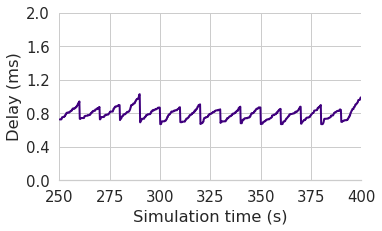

In [13]:
sns.set_palette (sns.color_palette (["#3f007d", "#3f007d", "#3f007d"]))
snsplt = sns.relplot(x="Time", y="Delay:ns", kind="line", legend=True, 
                      data=df_hw, ci=confianca, markers=True, height=3.5, aspect=1.6)
#plt.title('150Hosts - Delay')
snsplt.set_axis_labels("Simulation time (s)", "Delay (ms)")
if (titulos):
    snsplt.fig.suptitle('150 hosts - Delay', y=1.05)
#snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))
snsplt.set(ylim=(0, 2))
snsplt.set(yticks=(0,0.4,0.8,1.2,1.6,2))
snsplt.set(title='')
snsplt.fig.tight_layout()
if (salvarGraficos):
    snsplt.savefig("Graficos/150hosts-delay-movidos.pdf")

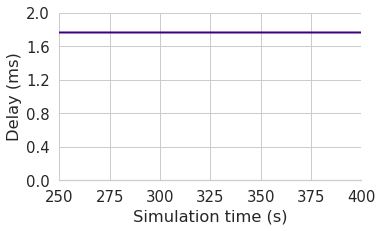

In [14]:
sns.set_palette (sns.color_palette (["#3f007d", "#3f007d", "#3f007d"]))
snsplt = sns.relplot(x="Time", y="Delay:ns", kind="line", legend=True, 
                      data=df_sw, ci=confianca, markers=True, height=3.5, aspect=1.6)
#plt.title('150Hosts - Delay')
snsplt.set_axis_labels("Simulation time (s)", "Delay (ms)")
if (titulos):
    snsplt.fig.suptitle('150 hosts - Delay', y=1.05)
#snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))
snsplt.set(ylim=(0, 2))
snsplt.set(yticks=(0,0.4,0.8,1.2,1.6,2))
snsplt.set(title='')
snsplt.fig.tight_layout()
if (salvarGraficos):
    snsplt.savefig("Graficos/150hosts-delay-naomovidos.pdf")

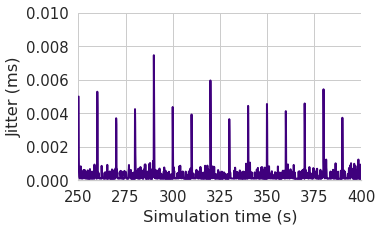

In [15]:
snsplt = sns.relplot(x="Time", y="Jitter:ns", col="InCache", kind="line", legend=True, 
                      data=df_hw, ci=confianca, markers=True, height=3.5, aspect=1.6)
#plt.title('150Hosts - Jitter')
snsplt.set_axis_labels("Simulation time (s)", "Jitter (ms)")
if (titulos):
    snsplt.fig.suptitle('150 hosts - Jitter', y=1.05)
#snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))
snsplt.set(ylim=(0, 0.01))
snsplt.set(yticks=(0,0.002,0.004,0.006,0.008,0.01))
snsplt.set(title='')
snsplt.fig.tight_layout()
if (salvarGraficos):
    snsplt.savefig("Graficos/150hosts-jitter-movidos.pdf")

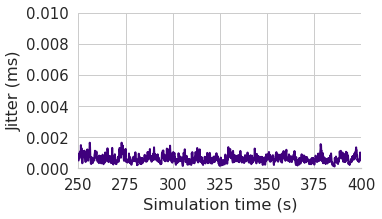

In [16]:
snsplt = sns.relplot(x="Time", y="Jitter:ns", col="InCache", kind="line", legend=True, 
                      data=df_sw, ci=confianca, markers=True, height=3.5, aspect=1.6)
#plt.title('150Hosts - Jitter')
snsplt.set_axis_labels("Simulation time (s)", "Jitter (ms)")
if (titulos):
    snsplt.fig.suptitle('150 hosts - Jitter', y=1.05)
#snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))
snsplt.set(ylim=(0, 0.01))
snsplt.set(yticks=(0,0.002,0.004,0.006,0.008,0.01))
snsplt.fig.tight_layout()
snsplt.set(title='')
if (salvarGraficos):
    snsplt.savefig("Graficos/150hosts-jitter-naomovidos.pdf")

In [17]:
df_hw = 0
df_sw = 0